# Correct for paper Fig 11 on FWHM : Data/Sim comparison 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : May 27th 2020
- update : June 1 2020

add R300 sim for comparison


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

In [4]:
from scipy.interpolate import interp1d

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [6]:
from scipy.interpolate import interp1d

## Constants for conversions

In [7]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_micr=1e3
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm
nm_to_micr=0.001

In [8]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [9]:
deg_to_rad=np.pi/180.

In [10]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [11]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
plt_scale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

#### filter

In [12]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [13]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file beam

In [14]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [15]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [16]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [17]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [18]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [19]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [20]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [21]:
WLSIM=np.array([400.,600.,800.,1000.])

# functions

## Utility

In [22]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Dispersion and dispersion rate

In [23]:
def Dispersion(wl,a,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in microns and lambdas in microns
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

In [24]:
def Dispersion_Rate(wl,a,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D/a*(np.sqrt(1-(wl/a)**2)+ (wl/a)**2)/(1-(wl/a)**2)
    return dxdlambda 

In [25]:
def Dispersion_Rate2(wl,a,D,p=1):
    """
    Dispersion_Rate(wl) for order 2: number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    - p : order
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D*p/a/(np.sqrt(1-(p*wl/a)**2))**3
    return dxdlambda 

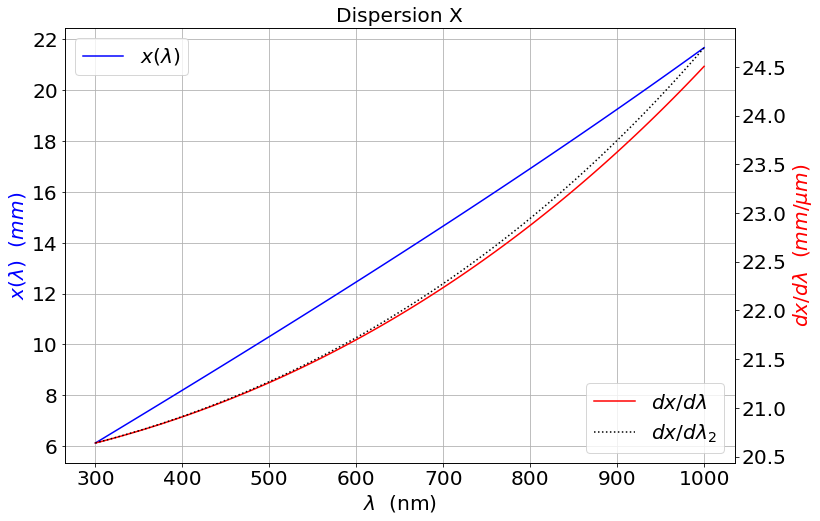

In [26]:
fig, ax1 = plt.subplots(figsize=(12,8))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm  ## mm per microns
Y3=Dispersion_Rate2(WL*nm_to_micr,a,D)*micr_to_mm  ## mm per microns
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL, Y3,"k:",label="$dx/d\lambda_2$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/\mu m$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

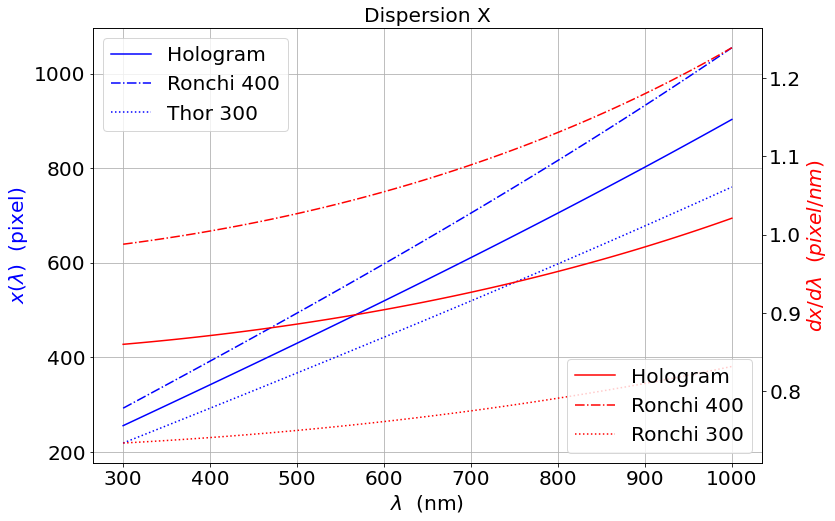

In [27]:
fig, ax1 = plt.subplots(figsize=(12,8))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel
Y1400=Dispersion(WL*nm_to_micr,1/400.*mm_to_micr,D)/Det_xpic   # pixel
Y1300=Dispersion(WL*nm_to_micr,1/300.*mm_to_micr,D)/Det_xpic   # pixel
ax1.plot(WL,Y1,"b",label="Hologram")
ax1.plot(WL,Y1400,"b-.",label="Ronchi 400")
ax1.plot(WL,Y1300,"b:",label="Thor 300")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2,"r",label="Hologram")
Y2400=Dispersion_Rate(WL*nm_to_micr,1/400.*mm_to_micr,D)/Det_xpic*1e-3   # pixel per nm
Y2300=Dispersion_Rate(WL*nm_to_micr,1/300.*mm_to_micr,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2400,"r-.",label="Ronchi 400")
ax2.plot(WL, Y2300,"r:",label="Ronchi 300")

ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

# Read the image of the data on FWMH (paper image)

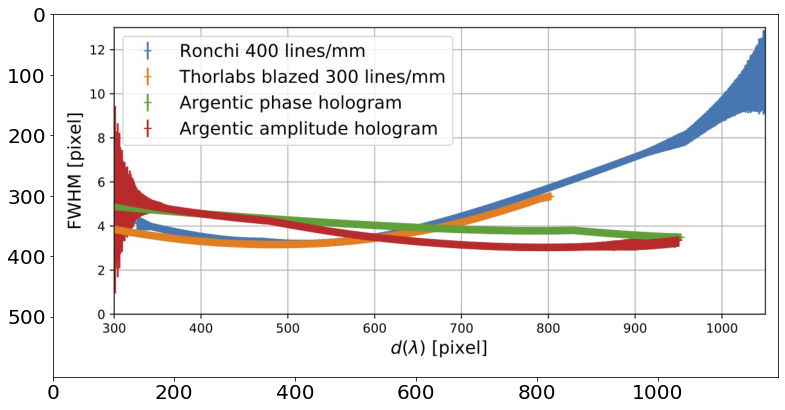

In [28]:
img = plt.imread("FWHM.jpg")
fig, ax = plt.subplots()
ax.imshow(img)

# Input Data Files

- previous image scanned with PlotDigitizer

In [29]:
dirdata="dataFWHM"

In [30]:
file_R400=os.path.join(dirdata,"FWHMR_400_rawdata.csv")
file_T300=os.path.join(dirdata,"FWHM_Thor300_v2.csv")
file_HoloPhAg=os.path.join(dirdata,"FWHM_HoloPhAg.csv")
file_HoloAmAg=os.path.join(dirdata,"FWHM_HoloAmAg.csv")

# Read Data

## Ronchi 400

In [31]:
df_R400=pd.read_csv(file_R400,header=3,index_col=False)

In [32]:
df_R400.head()

,X,Y
0,329.950,4.05479
1,360.597,3.75342
2,401.692,3.47945
3,431.642,3.34247
4,462.985,3.23288


## Thor 300

In [33]:
df_T300=pd.read_csv(file_T300,index_col=False,header=0)

In [34]:
df_T300.head()

,_n,_x,_y,_dx,_dy
0,0,111.0,359.0,307.147741,3.770061
1,1,165.0,368.0,344.709695,3.519402
2,2,237.0,378.0,394.795067,3.240235
3,3,295.0,382.0,435.147227,3.126971
4,4,351.0,383.0,474.111893,3.096384


In [35]:
df_T300=df_T300.drop(["_n","_x","_y"],axis=1)

In [36]:
df_T300=df_T300.rename({'_dx': 'X', '_dy': 'Y'}, axis=1) 

## Holo PhAg

In [37]:
df_HoloPhAg= pd.read_csv(file_HoloPhAg,index_col=False,header=3)

In [38]:
df_HoloPhAg.head()

,X,Y
0,305.811,4.87108
1,336.419,4.70353
2,379.558,4.64510
3,417.821,4.50447
4,464.434,4.36319


## Holo AmAg

In [39]:
df_HoloAmAg= pd.read_csv(file_HoloAmAg,index_col=False,header=0)

In [40]:
df_HoloAmAg.head()

,_n,_x,_y,_dx,_dy
0,0,127.0,313.0,318.805970,5.013699
1,1,180.0,322.0,355.721393,4.767123
2,2,232.0,329.0,391.940299,4.575342
3,3,288.0,336.0,430.945274,4.383562
4,4,335.0,340.0,463.681592,4.273973


In [41]:
df_HoloAmAg=df_HoloAmAg.drop(["_n","_x","_y"],axis=1)

In [42]:
df_HoloAmAg=df_HoloAmAg.rename({'_dx': 'X', '_dy': 'Y'}, axis=1) 

Text(0.5, 1.0, 'Disperser resolution')

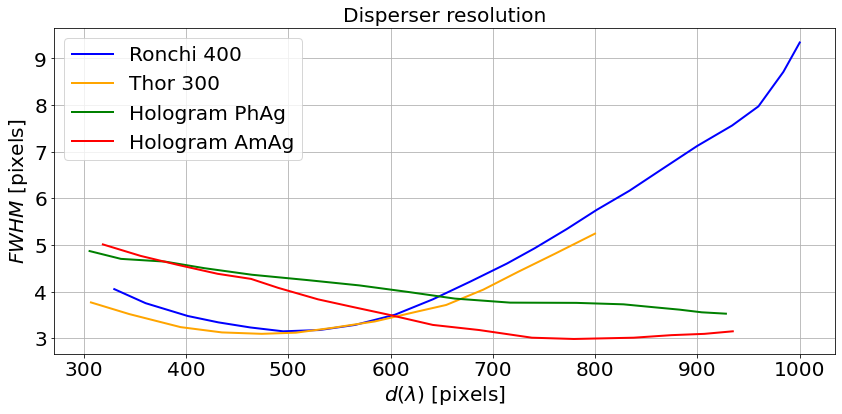

In [43]:
plt.figure(figsize=(14,6))
plt.plot(df_R400["X"],df_R400["Y"],color="blue",label="Ronchi 400",lw=2)
plt.plot(df_T300["X"],df_T300["Y"],color="orange",label="Thor 300",lw=2)
plt.plot(df_HoloPhAg["X"],df_HoloPhAg["Y"],color="green",label="Hologram PhAg",lw=2)
plt.plot(df_HoloAmAg["X"], df_HoloAmAg["Y"],color="red",label="Hologram AmAg",lw=2)
plt.legend()
plt.grid()
plt.xlabel("$d(\lambda)$ [pixels]")
plt.ylabel("$FWHM$ [pixels]")
plt.title("Disperser resolution")

# Conversion

In [44]:
WL=np.linspace(200.,1200.,100)
D=58*mm_to_micr

In [45]:
WL=np.linspace(200.,1200.,100)
#----------
# Thor 300
#----------
a=1/300.*mm_to_micr

## deviation
DX_mm=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm  # mm
DX_pix=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel
## dispersion rate
DX_mmperDLmic=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm    # mm per microns
DXpixperDLnm=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3  # pixel per nm

T300_DXpix_to_DWL=interp1d(DX_pix,WL, kind='cubic')  # convert deviation in pixel into wavelength
T300_FWHMpix_to_FWHM_mm=interp1d(WL,DXpixperDLnm,kind='cubic')  # convert WL into cooresponding DxpixdivdWL_nm

X_T300=T300_DXpix_to_DWL(df_T300["X"])  # convert pixels to WL in nm
Y_T300=df_T300["Y"]*Det_xpic*micr_to_mm       

In [46]:
#----------
# R 400
#----------
a=1/400.*mm_to_micr

## deviation
DX_mm=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm  # mm
DX_pix=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel

R400_DXpix_to_DWL=interp1d(DX_pix,WL, kind='cubic')  # convert deviation in pixel into wavelength

X_R400=R400_DXpix_to_DWL(df_R400["X"])  # convert pixels to WL in nm
Y_R400=df_R400["Y"]*Det_xpic*micr_to_mm  


In [47]:
#----------
# H 350
#----------
a=1/350.*mm_to_micr

## deviation
DX_mm=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm  # mm
DX_pix=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel

H350_DXpix_to_DWL=interp1d(DX_pix,WL, kind='cubic')  # convert deviation in pixel into wavelength


X_HoloPhAg=H350_DXpix_to_DWL(df_HoloPhAg["X"])  # convert pixels to WL in nm
Y_HoloPhAg=df_HoloPhAg["Y"]*Det_xpic*micr_to_mm  


X_HoloAmAg=H350_DXpix_to_DWL(df_HoloAmAg["X"])  # convert pixels to WL in nm
Y_HoloAmAg=df_HoloAmAg["Y"]*Det_xpic*micr_to_mm  

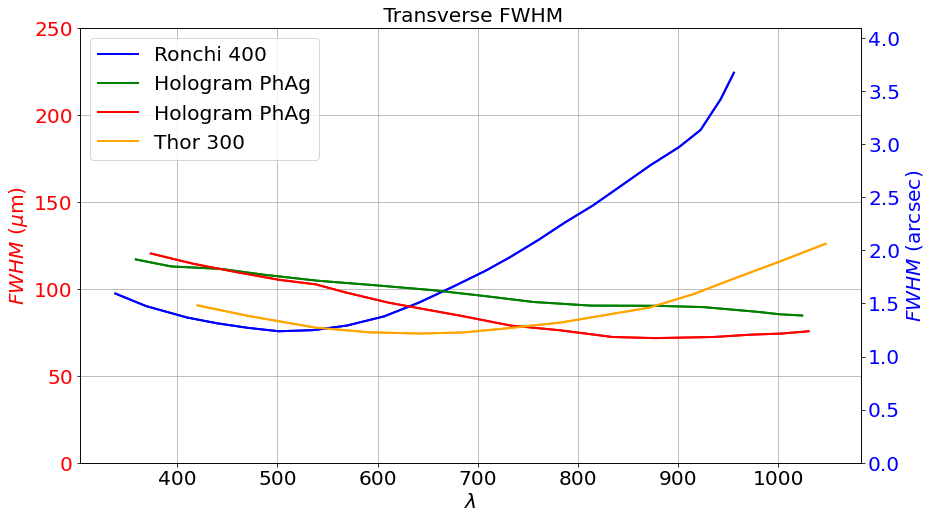

In [48]:
fig, ax1 = plt.subplots(figsize=(14,8))

#color = 'tab:red'
color = 'red'

ax1.set_ylim(0,250)
ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)
ax1.plot(X_HoloPhAg,Y_HoloPhAg*mm_to_micr,color="green",label="Hologram PhAg",lw=2)
ax1.plot(X_HoloAmAg,Y_HoloAmAg*mm_to_micr,color="red",label="Hologram PhAg",lw=2)
ax1.plot(X_T300,Y_T300*mm_to_micr,color="orange",label="Thor 300",lw=2)

ax1.set_title(" Transverse FWHM")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$FWHM$ ($\mu$m)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'

ax2.plot(X_R400,Y_R400*plt_scale,color="blue",lw=2)
ax2.plot(X_HoloPhAg,Y_HoloPhAg*plt_scale,color="green",lw=2)
ax2.plot(X_HoloAmAg,Y_HoloAmAg*plt_scale,color="red",lw=2)
ax2.plot(X_T300,Y_T300*plt_scale,color="orange",lw=2)
ax2.set_ylabel('$FWHM$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_ylim(0,0.25*plt_scale)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("PSF_FWHM_DATACTIO_v0.pdf")
plt.show()


# Read simulation

In [49]:
disperser_name=["Ronchi 400","Ronchi 350","Ronchi 300","Ronchi 200","Hologram"]
disperser_color=["k","b","y","g","r"]

In [50]:
infileR400data_excel="R400_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR350data_excel="R350_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR200data_excel="R200_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR300data_excel="R300_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileHOEdata_excel="HOE_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"

In [51]:
all_simfiles=[infileR400data_excel,infileR350data_excel,infileR300data_excel,infileR200data_excel,infileHOEdata_excel]

In [52]:
all_simdf=[]

for file in all_simfiles:
    df = pd.read_excel(file,index_col=0)
    
    #
    df["a"]=df["xmax"]-df["xav"]
    df["b"]=df["xav"]-df["xmin"]
    df["RXmax"]=df[["a","b"]].apply(max, axis=1)
    df.drop(["a","b"],axis=1,inplace=True)
    df["FWHMx"]=df["RXmax"]*np.sqrt(3)
    
    #
    df["a"]=df["ymax"]-df["yav"]
    df["b"]=df["yav"]-df["ymin"]
    df["RYmax"]=df[["a","b"]].apply(max, axis=1)
    df.drop(["a","b"],axis=1,inplace=True)
    df["FWHMy"]=df["RYmax"]*np.sqrt(3)
    
    all_simdf.append(df)

In [53]:
df

,xav,xstd,xmin,xmax,xwdt,xfwhm,xrmax,yav,ystd,ymin,ymax,ywdt,yfwhm,yrmax,RXmax,FWHMx,RYmax,FWHMy
400nm,8.314969,0.019111,8.27777,8.35273,0.07496,0.054516,0.037761,-1.499144e-19,0.006584,-0.01292,0.01292,0.02584,0.018793,0.01292,0.037761,0.065404,0.01292,0.022378
600nm,12.635639,0.004811,12.62626,12.64513,0.01887,0.013724,0.009491,1.606225e-20,0.001650,-0.00324,0.00324,0.00648,0.004713,0.00324,0.009491,0.016438,0.00324,0.005612
800nm,17.167191,0.027634,17.11278,17.22117,0.10839,0.078829,0.054411,-8.566536e-19,0.009384,-0.01842,0.01842,0.03684,0.026793,0.01842,0.054411,0.094243,0.01842,0.031904
1000nm,22.008016,0.082128,21.84664,22.16877,0.32213,0.234276,0.161376,2.826957e-18,0.027429,-0.05383,0.05383,0.10766,0.078298,0.05383,0.161376,0.279511,0.05383,0.093236


## Using hypothesis : $FWHM = \sqrt{3} R_{max} $

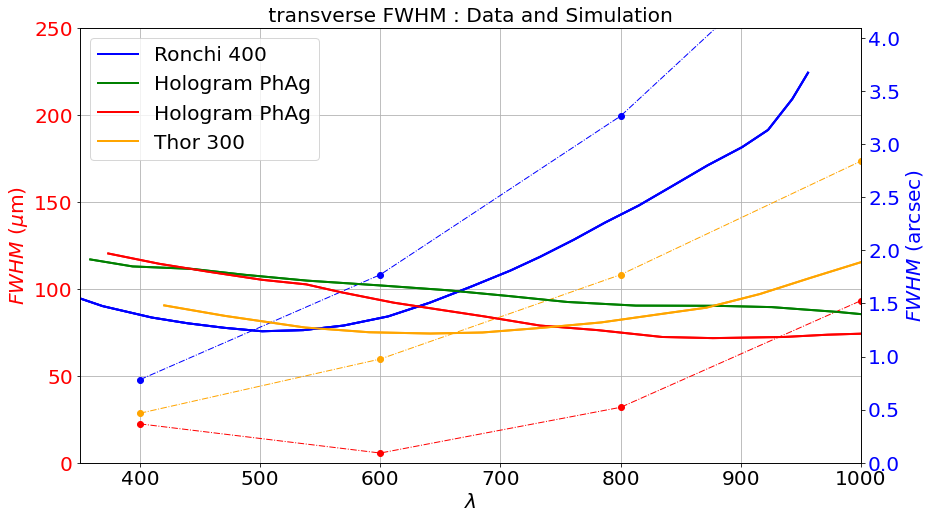

In [54]:
fig, ax1 = plt.subplots(figsize=(14,8))

#color = 'tab:red'
color = 'red'

ax1.set_ylim(0,250)
ax1.set_xlim(350,1000)
ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)
ax1.plot(X_HoloPhAg,Y_HoloPhAg*mm_to_micr,color="green",label="Hologram PhAg",lw=2)
ax1.plot(X_HoloAmAg,Y_HoloAmAg*mm_to_micr,color="red",label="Hologram PhAg",lw=2)
ax1.plot(X_T300,Y_T300*mm_to_micr,color="orange",label="Thor 300",lw=2)

ax1.set_title(" transverse FWHM : Data and Simulation ")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$FWHM$ ($\mu$m)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)

# simlulation
sim_R400=all_simdf[0]
ax1.plot(WLSIM,sim_R400["FWHMy"].values*mm_to_micr,"o-.",color="blue",lw=1)
#ax1.plot(WLSIM,sim_R400["RXmax"].values*mm_to_micr,"o-.",color="blue",lw=1)

sim_R300=all_simdf[2]
ax1.plot(WLSIM,sim_R300["FWHMy"].values*mm_to_micr,"o-.",color="orange",lw=1)
#ax1.plot(WLSIM,sim_R300["RYmax"].values*mm_to_micr,"o-.",color="orange",lw=1)

sim_HOE=all_simdf[4]
ax1.plot(WLSIM,sim_HOE["FWHMy"].values*mm_to_micr,"o-.",color="red",lw=1)
#ax1.plot(WLSIM,sim_HOE["RYmax"].values*mm_to_micr,"o-.",color="red",lw=1)

# arcsec axis

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'

ax2.plot(X_R400,Y_R400*plt_scale,color="blue",lw=2)
ax2.plot(X_HoloPhAg,Y_HoloPhAg*plt_scale,color="green",lw=2)
ax2.plot(X_HoloAmAg,Y_HoloAmAg*plt_scale,color="red",lw=2)
ax2.plot(X_T300,Y_T300*plt_scale,color="orange",lw=2)
ax2.set_ylabel('$FWHM$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_xlim(350,1000)
ax2.set_ylim(0,0.25*plt_scale)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("PSF_FWHM_DATASIMCTIO_v1.pdf")
plt.show()



## Using hypothesis : $FWHM = 2.36 \sigma $

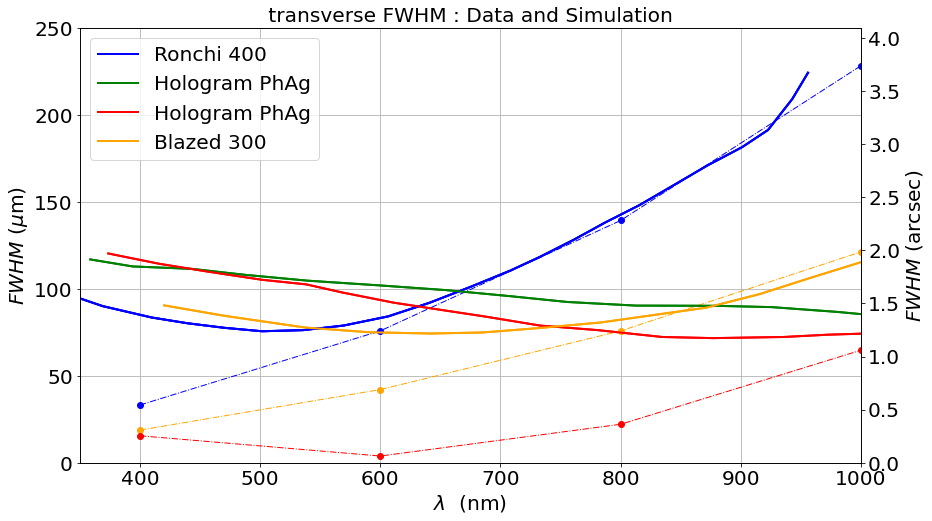

In [55]:
fig, ax1 = plt.subplots(figsize=(14,8))

#color = 'tab:red'
color = 'red'

ax1.set_ylim(0,250)
ax1.set_xlim(350,1000)
ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)
ax1.plot(X_HoloPhAg,Y_HoloPhAg*mm_to_micr,color="green",label="Hologram PhAg",lw=2)
ax1.plot(X_HoloAmAg,Y_HoloAmAg*mm_to_micr,color="red",label="Hologram PhAg",lw=2)
ax1.plot(X_T300,Y_T300*mm_to_micr,color="orange",label="Blazed 300",lw=2)

ax1.set_title(" transverse FWHM : Data and Simulation ")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$FWHM$ ($\mu$m)",color="k")
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor="k")

ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)

# simlulation
sim_R400=all_simdf[0]
ax1.plot(WLSIM,sim_R400["ystd"].values*mm_to_micr*2.36,"o-.",color="blue",lw=1)
#ax1.plot(WLSIM,sim_R400["RXmax"].values*mm_to_micr,"o-.",color="blue",lw=1)

sim_R300=all_simdf[2]
ax1.plot(WLSIM,sim_R300["ystd"].values*mm_to_micr*2.36,"o-.",color="orange",lw=1)
#ax1.plot(WLSIM,sim_R300["RYmax"].values*mm_to_micr,"o-.",color="orange",lw=1)

sim_HOE=all_simdf[4]
ax1.plot(WLSIM,sim_HOE["ystd"].values*mm_to_micr*2.36,"o-.",color="red",lw=1)
#ax1.plot(WLSIM,sim_HOE["RYmax"].values*mm_to_micr,"o-.",color="red",lw=1)

# arcsec axis

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'

ax2.plot(X_R400,Y_R400*plt_scale,color="blue",lw=2)
ax2.plot(X_HoloPhAg,Y_HoloPhAg*plt_scale,color="green",lw=2)
ax2.plot(X_HoloAmAg,Y_HoloAmAg*plt_scale,color="red",lw=2)
ax2.plot(X_T300,Y_T300*plt_scale,color="orange",lw=2)
ax2.set_ylabel('$FWHM$ (arcsec)', color="k")  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor="k")

ax2.set_xlim(350,1000)
ax2.set_ylim(0,0.25*plt_scale)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("PSF_FWHM_DATASIMCTIO_v2.pdf")
plt.show()




## Using hypothesis : computed FWHM

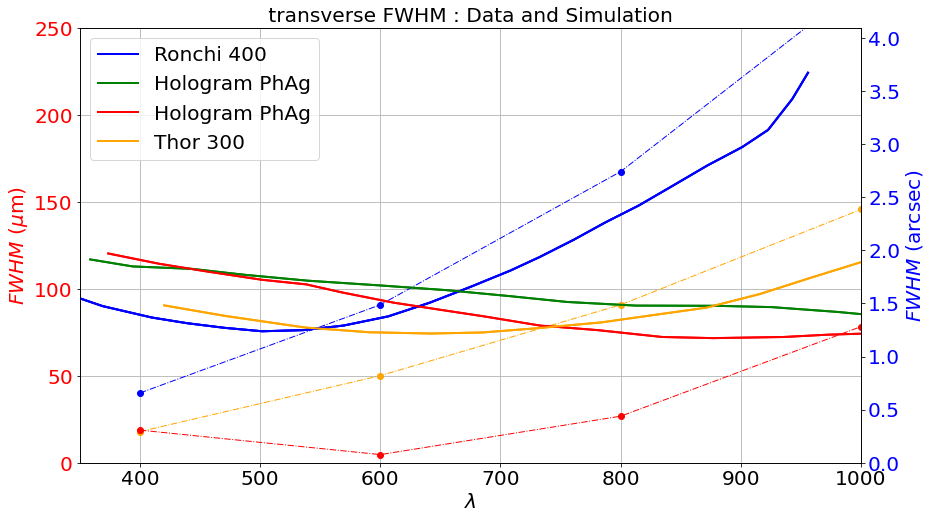

In [56]:
fig, ax1 = plt.subplots(figsize=(14,8))

#color = 'tab:red'
color = 'red'

ax1.set_ylim(0,250)
ax1.set_xlim(350,1000)
ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)
ax1.plot(X_HoloPhAg,Y_HoloPhAg*mm_to_micr,color="green",label="Hologram PhAg",lw=2)
ax1.plot(X_HoloAmAg,Y_HoloAmAg*mm_to_micr,color="red",label="Hologram PhAg",lw=2)
ax1.plot(X_T300,Y_T300*mm_to_micr,color="orange",label="Thor 300",lw=2)

ax1.set_title(" transverse FWHM : Data and Simulation ")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$FWHM$ ($\mu$m)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)

# simlulation
sim_R400=all_simdf[0]
ax1.plot(WLSIM,sim_R400["yfwhm"].values*mm_to_micr,"o-.",color="blue",lw=1)
#ax1.plot(WLSIM,sim_R400["RXmax"].values*mm_to_micr,"o-.",color="blue",lw=1)

sim_R300=all_simdf[2]
ax1.plot(WLSIM,sim_R300["yfwhm"].values*mm_to_micr,"o-.",color="orange",lw=1)
#ax1.plot(WLSIM,sim_R300["RYmax"].values*mm_to_micr,"o-.",color="orange",lw=1)

sim_HOE=all_simdf[4]
ax1.plot(WLSIM,sim_HOE["yfwhm"].values*mm_to_micr,"o-.",color="red",lw=1)
#ax1.plot(WLSIM,sim_HOE["RYmax"].values*mm_to_micr,"o-.",color="red",lw=1)

# arcsec axis

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'

ax2.plot(X_R400,Y_R400*plt_scale,color="blue",lw=2)
ax2.plot(X_HoloPhAg,Y_HoloPhAg*plt_scale,color="green",lw=2)
ax2.plot(X_HoloAmAg,Y_HoloAmAg*plt_scale,color="red",lw=2)
ax2.plot(X_T300,Y_T300*plt_scale,color="orange",lw=2)
ax2.set_ylabel('$FWHM$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_xlim(350,1000)
ax2.set_ylim(0,0.25*plt_scale)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("PSF_FWHM_DATASIMCTIO_v3.pdf")
plt.show()


# New FWHM from beam resampling

In [57]:
WLSIM

array([ 400.,  600.,  800., 1000.])

In [58]:
FWHMX_HOE_SIMBEAM = np.array([63,15,89,271])
FWHMY_HOE_SIMBEAM = np.array([22,6,30,90])

In [59]:
FWHMX_R400_SIMBEAM = np.array([124,325,585,1043])
FWHMY_R400_SIMBEAM = np.array([41,99,184,316])

In [60]:
FWHMX_R300_SIMBEAM = np.array([64,164,301,505])
FWHMY_R300_SIMBEAM = np.array([20,53,102,165])

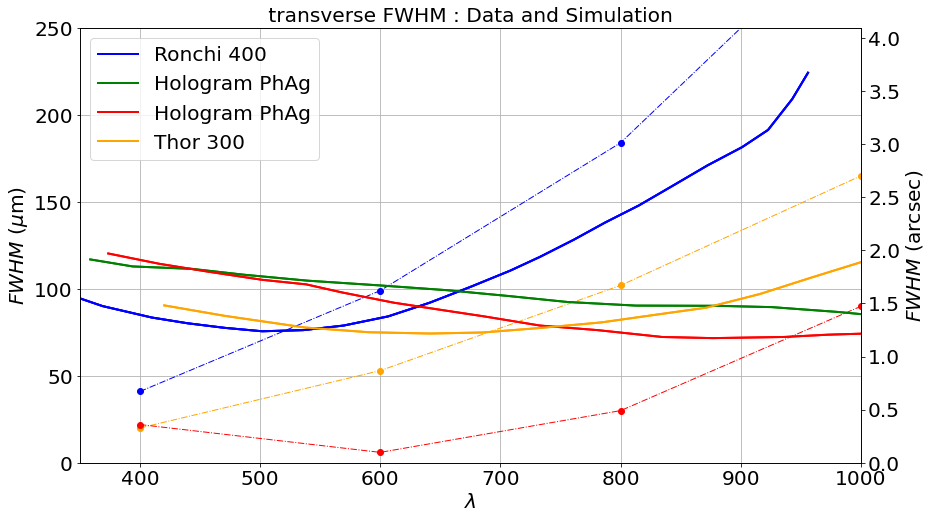

In [61]:
fig, ax1 = plt.subplots(figsize=(14,8))

#color = 'tab:red'
color = 'k'

ax1.set_ylim(0,250)
ax1.set_xlim(350,1000)
ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)
ax1.plot(X_HoloPhAg,Y_HoloPhAg*mm_to_micr,color="green",label="Hologram PhAg",lw=2)
ax1.plot(X_HoloAmAg,Y_HoloAmAg*mm_to_micr,color="red",label="Hologram PhAg",lw=2)
ax1.plot(X_T300,Y_T300*mm_to_micr,color="orange",label="Thor 300",lw=2)

ax1.set_title(" transverse FWHM : Data and Simulation ")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$FWHM$ ($\mu$m)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(X_R400,Y_R400*mm_to_micr,color="blue",label="Ronchi 400",lw=2)

# simlulation
sim_R400=all_simdf[0]
ax1.plot(WLSIM,FWHMY_R400_SIMBEAM,"o-.",color="blue",lw=1)


sim_R300=all_simdf[2]
ax1.plot(WLSIM,FWHMY_R300_SIMBEAM,"o-.",color="orange",lw=1)
#ax1.plot(WLSIM,sim_R300["RYmax"].values*mm_to_micr,"o-.",color="orange",lw=1)

sim_HOE=all_simdf[4]
ax1.plot(WLSIM,FWHMY_HOE_SIMBEAM,"o-.",color="red",lw=1)
#ax1.plot(WLSIM,sim_HOE["RYmax"].values*mm_to_micr,"o-.",color="red",lw=1)

# arcsec axis

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'k'

ax2.plot(X_R400,Y_R400*plt_scale,color="blue",lw=2)
ax2.plot(X_HoloPhAg,Y_HoloPhAg*plt_scale,color="green",lw=2)
ax2.plot(X_HoloAmAg,Y_HoloAmAg*plt_scale,color="red",lw=2)
ax2.plot(X_T300,Y_T300*plt_scale,color="orange",lw=2)

ax2.set_ylabel('$FWHM$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_xlim(350,1000)
ax2.set_ylim(0,0.25*plt_scale)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("PSF_FWHM_DATASIMCTIO_v4.pdf")
plt.show()

